In [0]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, Add, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

#import efficientnet.tfkeras as efn

import os, sys, glob
import datetime

In [25]:
EPOCHS = 100
#배치 사이즈
BATCH_SIZE = 16
#모델 이름(cnn, vgg, efn, resnet)
MODEL_NAME = 'vgg'
#Check point 설정
CHECKPOINT_PATH = '/content/saved_models/2cp-{}{}.h5'.format(MODEL_NAME, EPOCHS)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

#데이터 경로
path = ['/content/medi/no_receipt/*', '/content/medi/receipt/*']

def preprocess(path, label):
    img_array = []
    img_label = []
    for cls in range(len(label)):
        imglist = glob.glob(path[cls])
        for i, name in enumerate(imglist):
            img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
            #cv2는 일반 배열이랑 반대
            img_resize = cv2.resize(img,(360,640))
            img_thres = cv2.adaptiveThreshold(img_resize, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,9, 3)
            img_thres = img_thres.astype('float32') / 255 # 0 ~ 1
            img_array.append(img_thres.reshape(640,360,1))
            img_label.append(label[cls])
        print('{}인 레이블 : '.format(label[cls]) , len(imglist))
    return np.array(img_array), np.array(img_label)

imgs, labels = preprocess(path, list([0,1]))

0인 레이블 :  1101
1인 레이블 :  628


In [5]:
!pwd

/content/medi


In [8]:
%cd no_receipt

/content/medi/no_receipt


In [0]:
!rm -r *

In [26]:
VALIDATION_VALUE = 0.1
TEST_VALUE = 0.1
TRAIN_VALUE = 1 - VALIDATION_VALUE - TEST_VALUE

print("Train Data 비율 : %.1f" %TRAIN_VALUE)
print("Validation Data 비율 : ", VALIDATION_VALUE)
print("Test Data 비율 : ", TEST_VALUE)

val_size = int(imgs.shape[0] * VALIDATION_VALUE)
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size = TEST_VALUE, random_state=1)

x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]


Train Data 비율 : 0.8
Validation Data 비율 :  0.1
Test Data 비율 :  0.1


In [30]:
base_model = VGG16(input_shape=(640,360,1),weights=None, include_top=False)
base_model.trainable = True
global_max_layer = GlobalMaxPooling2D()

model = Sequential()
model.add(base_model)
model.add(Conv2D(512, kernel_size=3, strides=1,activation='relu', padding='same'))

model.add(GlobalMaxPooling2D())
#         model.add(Dense(256,activation='relu'))
#         model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

adam = Adam(lr=1e-05)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])
#model.load_weights('/content/cp-vgg100.h5')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 20, 11, 512)       14713536  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 11, 512)       2359808   
_________________________________________________________________
global_max_pooling2d_7 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 17,073,857
Trainable params: 17,073,857
Non-trainable params: 0
_________________________________________________________________


In [28]:
x_train.shape

(1384, 640, 360, 1)

In [22]:
%cd /content/medi/no_receipt

/content/medi/no_receipt


In [0]:
!rm -r *

In [31]:
check_point = ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto')

history = model.fit(x_train, y_train, epochs = 100, batch_size = 8, validation_data=(x_val, y_val),callbacks=[early_stopping, check_point])


Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.6366
Epoch 00001: saving model to /content/saved_models/2cp-vgg100.h5
173/173 [==============================] - 130s 749ms/step - loss: 0.6605 - accuracy: 0.6366 - val_loss: 0.6681 - val_accuracy: 0.6047
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7146
Epoch 00002: saving model to /content/saved_models/2cp-vgg100.h5
173/173 [==============================] - 131s 755ms/step - loss: 0.5319 - accuracy: 0.7146 - val_loss: 0.3914 - val_accuracy: 0.8198
Epoch 3/100
173/173 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8439
Epoch 00003: saving model to /content/saved_models/2cp-vgg100.h5
173/173 [==============================] - 131s 755ms/step - loss: 0.3396 - accuracy: 0.8439 - val_loss: 0.2910 - val_accuracy: 0.8837
Epoch 4/100
173/173 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9010
Epoch 00004:

KeyboardInterrupt: ignored

In [0]:
model.save('/content/binary_classification4.h5')

In [35]:
def predict(history, x_test):
    predict = model.predict(x_test)
    predict_label = []
    for i in range(len(predict)):
        predict_label.append(np.argmax(predict[i]))
    print('test value : ', np.mean(y_test== predict_label))    
    
    y_loss = history.history['loss']
    y_val_loss = history.history['val_loss']
    y_acc = history.history['accuracy']
    y_val_acc = history.history['val_accuracy']

    x = np.arange(0, len(y_loss))

    fig, axes = plt.subplots(figsize=(20,10))
    axes.plot(x, y_loss, marker = '*', color = 'red', label = 'loss')
    axes.plot(x, y_val_loss, marker='h' ,label = 'val_loss')

    another = axes.twinx()
    another.plot(x, y_acc, color = 'green', label = "acc")
    another.plot(x, y_val_acc, color = 'blue', label = "val_acc" )

    axes.legend(loc = 'upper left')
    another.legend(loc='lower left')

    plt.show()
predict(history, x_test)

NameError: ignored

In [34]:
model.evaluate(x_test, y_test,batch_size=8)

22/22 [==============================] - 6s 295ms/step - loss: 0.0141 - accuracy: 1.0000


[0.014069014228880405, 1.0]

In [0]:
pred = model.predict(x_test)

In [0]:
pred_label = []
for i in range(len(pred)):
    pred_label.append(np.argmax(pred[i]))

In [88]:
np.mean(pred_label == y_test)

0.9811320754716981

In [64]:
y_test

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])

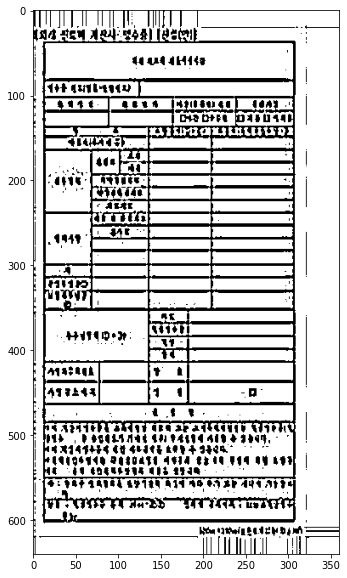

In [72]:
test_img = x_test[1].reshape(640,360)
plt.figure(figsize=(10,10))
plt.imshow(test_img, cmap='gray')

In [0]:
img = cv2.imread('/content/reer.jpg', cv2.IMREAD_GRAYSCALE)
            #cv2는 일반 배열이랑 반대
img_resize = cv2.resize(img,(360,640))
img_thres = cv2.adaptiveThreshold(img_resize, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,9, 3)
img_thres = img_thres.astype('float32') / 255

In [0]:
pred = model.predict(img_thres.reshape(1,640,360,1))


In [84]:
np.argmax(pred)

1

In [65]:
pred

array([[1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
MODEL_SAVE_FOLDER_PATH = './model/' 
if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
  os.mkdir(MODEL_SAVE_FOLDER_PATH) 
  model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5' 
  cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True) 
  # ... model.fit(X, Y, validation_split=0.2, epochs=200, batch_size=200, verbose=0, callbacks=[cb_checkpoint])
